In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [9]:
import pandas as pd
import datetime

def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, dates=None, use_future=False):
    """[summary]

    Args:
        samples: [description]
        time:    [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """

    if samples.shape[-1] != time:
        raise Exception("Samples second dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response



In [10]:
# https://github.com/google/jax/issues/10144
def transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.minimum(np.maximum(x, 0), pop)

def sir(x, dt, β, γ, N):
    """ SIR model

    Args:
        x[t]:  State space at time t.
        dt:    Recovery rate.
        β:     Contact rate.
        γ:     Recovery rate.
        N:     Population size.

    Returns:
        x[t+1]: State space at time t+1.
    """

    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()

    s2i = transition(S, β * I / N * dt)
    i2r = transition(I, γ * dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return checkpopvars(np.array([S, I, R, C]), N)


In [11]:
N = 1000

β = 0.3 # days
γ = 1/7 # days

# initial conditions
I0 = N * 0.01
S0 = N - I0
R0 = 0
C0 = 0

ens = 500
x0  = np.ones((4, ens)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)


T  = 365
dt = 1

x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = sir(x_sim.at[:, t-1, :].get(), 1, β, γ, N)
    x_sim = x_sim.at[:, t, :].set(x)


In [12]:
S =  x_sim.at[0, :, :].get(); S_df = create_df_response(S.T, T)
I =  x_sim.at[1, :, :].get(); I_df = create_df_response(I.T, T)
R =  x_sim.at[2, :, :].get(); R_df = create_df_response(R.T, T)
C =  x_sim.at[3, :, :].get(); C_df = create_df_response(C.T, T)


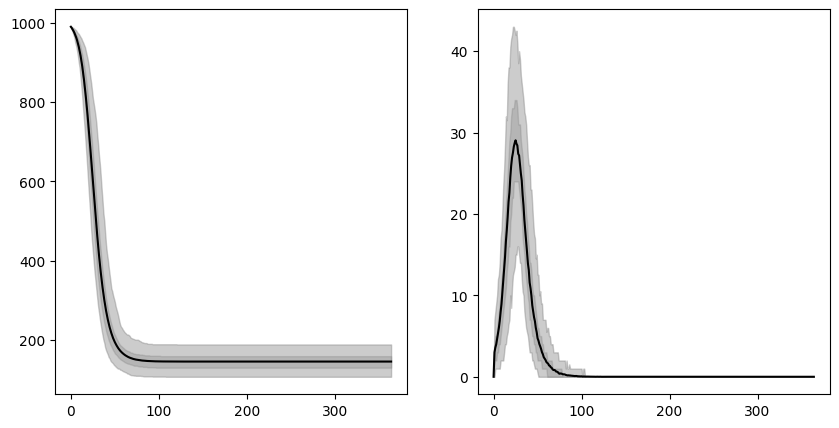

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(S_df.index, S_df['mean'], label='S', color="k")
ax[0].fill_between(S_df.index, S_df['low_95'], S_df['high_95'], alpha=0.4, color="gray")
ax[0].fill_between(S_df.index, S_df['low_50'], S_df['high_50'], alpha=0.3, color="gray")

ax[1].plot(C_df.index, C_df['mean'], label='S', color="k")
ax[1].fill_between(C_df.index, C_df['low_95'], C_df['high_95'], alpha=0.4, color="gray")
ax[1].fill_between(C_df.index, C_df['low_50'], C_df['high_50'], alpha=0.3, color="gray")

In [109]:
state_space = x_sim.at[:, 25, :].get()


In [110]:
def eakf(state_space, observation, oev, idx_obs=-1, update_space=True):

    num_vars, num_ens = state_space.shape

    obs_sim       = state_space.at[idx_obs, :].get()
    prior_mean_ct = obs_sim.mean(-1, keepdims=True)  # Average over ensemble members
    prior_var_ct  = obs_sim.var(-1, keepdims=True)   # Compute variance over ensemble members

    post_var_ct   = prior_var_ct * oev / (prior_var_ct + oev)
    post_mean_ct  = post_var_ct * (prior_mean_ct/prior_var_ct + observation / oev)
    alpha         = oev / (oev+prior_var_ct); alpha = alpha**0.5
    dy            = post_mean_ct + alpha*( obs_sim - prior_mean_ct ) - obs_sim

    A       = np.cov(state_space, obs_sim)
    covars  = A.at[:-1, -1].get()
    rr      = covars / prior_var_ct
    dx      = np.dot( np.expand_dims(rr, -1), np.expand_dims(dy, 0))